In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('final_preprocessed.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nTarget distribution:")
print(df['Outcome'].value_counts())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (768, 9)

Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Missing values:
Pregnancies                 0
Glucos

In [ ]:
# Separate features and target
X = df.drop(['Outcome'], axis=1)  # Remove target
y = df['Outcome']

print("Feature names:", X.columns.tolist())
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Features shape: (768, 8)
Target shape: (768,)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Training set: (614, 8)
Test set: (154, 8)
Training target distribution: [400 214]
Test target distribution: [100  54]


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled test data shape:", X_test_scaled.shape)

Scaled training data shape: (614, 8)
Scaled test data shape: (154, 8)


In [ ]:
# Define the model architecture
model = keras.Sequential([
    # Input layer
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Hidden layer 1
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Hidden layer 2
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer (binary classification)
    layers.Dense(1, activation='sigmoid')
])

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5165 - loss: 0.9856 - precision: 0.3246 - recall: 0.4386 - val_accuracy: 0.6504 - val_loss: 0.6684 - val_precision: 0.5094 - val_recall: 0.6136 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5949 - loss: 0.8076 - precision: 0.4443 - recall: 0.5456 - val_accuracy: 0.6911 - val_loss: 0.6088 - val_precision: 0.6250 - val_recall: 0.3409 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6458 - loss: 0.7600 - precision: 0.4792 - recall: 0.5822 - val_accuracy: 0.6911 - val_loss: 0.5810 - val_precision: 0.6667 - val_recall: 0.2727 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5942 - loss: 0.7528 - precision: 0.4688 - recall: 0.4875 - val_accuracy: 0.6748 - val_loss: 0.5636 - val_precision: 0.6667 - val_recall: 0.1818 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled, y_test, verbose=0
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7338
Test Precision: 0.6444
Test Recall: 0.5370
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154


Confusion Matrix:
[[84 16]
 [25 29]]


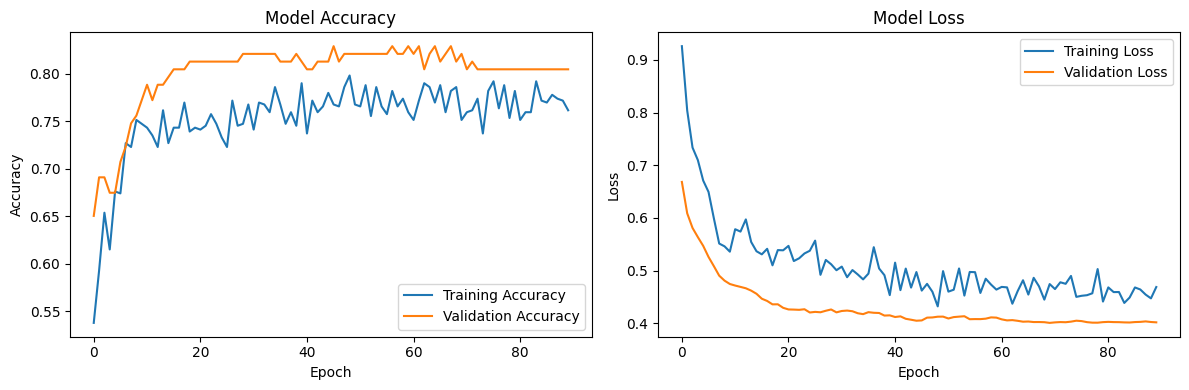

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Feature Importance:
                    feature  importance
1                   Glucose    0.057792
7                       Age    0.027273
0               Pregnancies    0.014286
2             BloodPressure    0.001948
4                   Insulin    0.000649
5                       BMI   -0.005195
6  DiabetesPedigreeFunction   -0.006494
3             SkinThickness   -0.010390


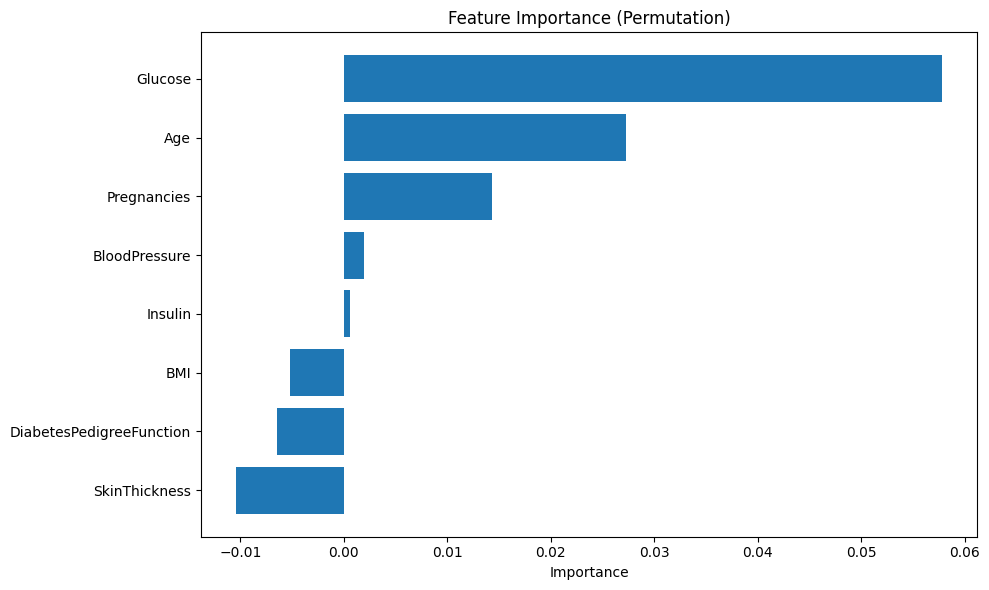

In [ ]:
# Get feature importance using permutation importance
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasClassifier

# Create a KerasClassifier instance and fit it to the training data
keras_model_wrapper = KerasClassifier(model=model, epochs=100, batch_size=32, verbose=0)
keras_model_wrapper.fit(X_train_scaled, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(
    keras_model_wrapper, # Use the fitted KerasClassifier instance
    X_test_scaled, y_test, n_repeats=10, random_state=42
)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model.save('diabetes_neural_network.h5')
print("Model saved as 'diabetes_neural_network.h5'")

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Model saved as 'diabetes_neural_network.h5'
Scaler saved as 'scaler.pkl'
